<div class="jumbotron text-left"><b>
    
This notebook describes how to perform an optimization of FAST-OAD using the SEGOMOE toolbox. 
    
The goal is to use a Bayesian Optimization (EGO method) to solve a constrained optimization problem with mixed variables. The idea is to use some dimension reduction methods as KPLS model when the number of design varaibles is too large.
<div>

    
Paul SAVES ONERA/DTIS/M2CI  \& Nathalie BARTOLI ONERA/DTIS/M2CI
    
FASTOAD version 0.5.4 
    
    
February 2021


<div class="alert alert-info fade in" id="d110">
<p>The idea is to </p>
<ol> - compare the COBYLA results in the fastoad tutorial with results from SEGO on a constrained optimization problem with continuous variables (1D problem) </ol>    
<ol> - use SEGO on a constrained optimization problem with mixed variables (10D problem) </ol>

</div>

## Import SEGO, FAST-OAD and other libraries

### The version of **FAST-OAD** is available here: https://github.com/fast-aircraft-design/FAST-OAD


In [2]:
from smt.sampling_methods import LHS
import numpy as np
import matplotlib.pyplot as plt
from smt.surrogate_models import KRG,KPLS, MGP
from smt.applications.mixed_integer import MixedIntegerSurrogateModel
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
import os
from smt.applications import EGO
import warnings
warnings.filterwarnings('ignore')
from smt.applications.mixed_integer import (
    FLOAT,
    INT,
    ENUM,
    MixedIntegerSamplingMethod,
    cast_to_mixed_integer,
    fold_with_enum_index,
    unfold_with_enum_mask
)
import time
import os.path as pth
from fastoad.io import VariableIO
from fastoad.utils.postprocessing.analysis_and_plots import wing_geometry_plot, \
drag_polar_plot, mass_breakdown_sun_plot, aircraft_geometry_plot, mass_breakdown_bar_plot
import shutil
import segomoe.cases.fastoad_rhea_prob as fastoad_prob
from segomoe.sego import Sego
from segomoe.sego_defs import print_sego_options
from segomoe.constraint import Constraint
import segomoe.cases.case_generator


from segomoe.egorse import Egorse
from segomoe.egorse_defs import print_egorse_options

Unable to import mpi4py. Parallel processing unavailable.
Unable to import petsc4py. Parallel processing unavailable.
Unable to import petsc4py. Parallel processing unavailable.
<module 'ntpath' from 'C:\\Users\\LA202059\\anaconda3\\envs\\py38\\lib\\ntpath.py'>


# Constrained Optimization with a continuous variable (1D problem)

### Problem definition

The idea here is to solve a constrained optimization problem with a continuous design variable with SEGO.
SEGO is used as an optimizer to do a Multidisciplinary Design Optimization based on a Overall Aircraft Design tool : FAST-OAD.

The problem is given by: 

$$\begin{array}{l}
\qquad  \min  \quad fuel \ mass \\
 \mbox{ with respect to } \\
\qquad \qquad data:geometry:wing:MAC:at25percent:x \in [16.0, 18.0]\\
 \mbox{ such that } \\
\qquad \qquad data:handling\_qualities:static\_margin < 0.1 \\
\qquad \qquad data:handling\_qualities:static\_margin > 0.05 \\
\end{array}
$$

###  Import problem definition

In [7]:
from  segomoe.cases.fastoad_rhea_prob import f_grouped
import os.path as pth
from Add_functions import generate_configuration_file

ng = "TPAD_hybrid_sego_optim_spyderAST_HTPEM_hyb_desc_"
#specify here the data and the workdir directory used by FASTOAD
DATA_FOLDER_PATH = "data"
WORK_FOLDER_PATH = "workdir"

print("Function ", ng)
RESULTS_FOLDER_PATH = "workdir/" + ng + "/"
base_save = ng

#os.mkdir(RESULTS_FOLDER_PATH)

#optim with gt initial climb rate as design variable and no hybrid descent
#CONFIGURATION_FILE = generate_configuration_file(RESULTS_FOLDER_PATH, pth.join(WORK_FOLDER_PATH, 'RHEA_TPAD_sizing_PHFC.toml'))

#optim without gt initial climb rate as design variable and hybrid descent
CONFIGURATION_FILE = generate_configuration_file(RESULTS_FOLDER_PATH, pth.join(WORK_FOLDER_PATH, 'RHEA_TPAD_sizing_PHFC_new.toml'))


SOURCE_FILE = pth.join(DATA_FOLDER_PATH, 'TPAD_hybrid.xml')

case = (segomoe.cases.case_generator._import_case("FASTOAD_RHEA"))(SOURCE_FILE,CONFIGURATION_FILE)




Function  TPAD_hybrid_sego_optim_spyderAST_HTPEM_hyb_desc_
workdir/TPAD_hybrid_sego_optim_spyderAST_HTPEM_hyb_desc_/RHEA_TPAD_sizing_PHFC_new.toml


The `toml` configuration file should contain some information:
- about the type of the variables (continuous, discrete or categorical)
- about the bounds intervals
- about the objective functions
- about the constraints to be respected


###  Defining sego optimization

Optimization without hybrid descent, with gt initial climb rate as design variable

In [4]:
'''n_con = 1
cst_names = [ "TTC_c1","FL_c4","FLdiv_c5","OEI_c6","TOFL_c7"]#
cst_th = [ 1013.,6095.,3047., 2943. ,1384. ]
#cst_th = [ 2013.,5095.,2047., 1943. ,2384. ]
cst_type = [ "<",">",">",">","<"]
cst_tol = [ 1e-1,1e-1,1e-1, 1e-1,1e-1]
# constraints

f_con0 = lambda point: f_c0(point, SOURCE_FILE, CONFIGURATION_FILE)
f_con1 = lambda point: f_c1(point, SOURCE_FILE, CONFIGURATION_FILE)
f_con2 = lambda point: f_c2(point, SOURCE_FILE, CONFIGURATION_FILE)
f_con3 = lambda point: f_c3(point, SOURCE_FILE, CONFIGURATION_FILE)
f_con4 = lambda point: f_c4(point, SOURCE_FILE, CONFIGURATION_FILE)
f_con5 = lambda point: f_c5(point, SOURCE_FILE, CONFIGURATION_FILE)
f_con6 = lambda point: f_c6(point, SOURCE_FILE, CONFIGURATION_FILE)
f_con7 = lambda point: f_c7(point, SOURCE_FILE, CONFIGURATION_FILE)
#con_fun = [f_con0, f_con1,f_con2,f_con3,f_con4,f_con5,f_con6]#,f_con7]  # stacking the constraints
#con_fun = [f_con1,f_con4,f_con5,f_con6,f_con7]  # stacking the constraints
con_fun = [f_con0,f_con1,f_con2,f_con3,f_con4]  # stacking the constraints

con = [
    Constraint(cst_type[i], cst_th[i], name=(cst_names[i]), f=g, tol=cst_tol[i])
    for i, g in enumerate(con_fun)
]
case["con"] = con'''

In [8]:
n_con = 1
cst_names = [ "TTC_c1","FL_c4","OEI_c6","TOFL_c7"]#
cst_th = [ 1013.,6095., 2943. ,1384. ]
#cst_th = [ 2013.,5095.,2047., 1943. ,2384. ]
cst_type = [ "<",">",">","<"]
cst_tol = [ 1e-1,1e-1, 1e-1,1e-1]
# constraints

f_con0 = lambda point: f_c0(point, SOURCE_FILE, CONFIGURATION_FILE)
f_con1 = lambda point: f_c1(point, SOURCE_FILE, CONFIGURATION_FILE)
f_con2 = lambda point: f_c2(point, SOURCE_FILE, CONFIGURATION_FILE)
f_con3 = lambda point: f_c3(point, SOURCE_FILE, CONFIGURATION_FILE)
f_con4 = lambda point: f_c4(point, SOURCE_FILE, CONFIGURATION_FILE)
f_con5 = lambda point: f_c5(point, SOURCE_FILE, CONFIGURATION_FILE)
f_con6 = lambda point: f_c6(point, SOURCE_FILE, CONFIGURATION_FILE)
f_con7 = lambda point: f_c7(point, SOURCE_FILE, CONFIGURATION_FILE)
#con_fun = [f_con0, f_con1,f_con2,f_con3,f_con4,f_con5,f_con6]#,f_con7]  # stacking the constraints
#con_fun = [f_con1,f_con4,f_con5,f_con6,f_con7]  # stacking the constraints
con_fun = [f_con0,f_con1,f_con2,f_con3]  # stacking the constraints

con = [
    Constraint(cst_type[i], cst_th[i], name=(cst_names[i]), f=g, tol=cst_tol[i])
    for i, g in enumerate(con_fun)
]
case["con"] = con

In [4]:
case["con"]

[Constraint(TTC_c1(x) < 1013 +/- 0.1),
 Constraint(FL_c4(x) > 6095 +/- 0.1),
 Constraint(OEI_c6(x) > 2943 +/- 0.1),
 Constraint(TOFL_c7(x) < 1384 +/- 0.1)]

In [11]:

var = case["vars"]
f_grouped = case["f_grouped"]
default_models = case["models"]

con = case["con"]
enable_f_grouped = True

n_optim = 1
n_iter = 0
n_doe =60#3x nb of variables

#filename_orig = os.path.join(RESULTS_FOLDER_PATH, base_save + "_" + str(0) + "_optim")

#filename = os.path.join(RESULTS_FOLDER_PATH, base_save + "_" + str(2) + "_optim")
#filename_orig = os.path.join(RESULTS_FOLDER_PATH, base_save + "_" + str(1) + "_optim")
#filename_orig = os.path.join(RESULTS_FOLDER_PATH, base_save + "_" + str(0) + "_optim")
filename = os.path.join(RESULTS_FOLDER_PATH, base_save + "_" + str(62) + "_optim")
filename_orig = os.path.join(RESULTS_FOLDER_PATH, base_save + "_" + str(61) + "_optim")


In [12]:

sego = Sego(
    f_grouped,  # grouped function
    var,  # design variables
    const=con,
    path_hs=filename_orig,
    optim_settings={
        "model_type": default_models,  # models
        "optimizer": "slsqp",
        "grouped_eval": enable_f_grouped,
        "size_doe": n_doe,  # size of the initial design of points
        "analytical_diff": False,  # analytical gradient for the acquisition function
        "obj_crit": "WB2S",
        "dir_out": filename,  # output directory to save results
        "n_clusters": 1,  # nb of clusters
        "debug": False,  # a logical parameter for debugging the code
        "cst_doubt": {
            "type": "Cst",
            "init": 3,
        },  # type of evolution on the constant doubt $\tau$
        "cst_crit": "MC",  # Possible values [UTB,UTB2,MC]
         'crit_opt_global':False,
    },
)

>>> SEGO Options selected:

[Optimization]

Optimizer: slsqp
Enrichment criterion: WB2S
Analytical jacobians: False
Smooth recombination: True
Optimization validation: True
Mode: Minimisation
Size DOE: 60
Grouped eval: True
Multiprocessing eval: False
Model type: user defined
Nb clusters: 1
Reclustering rate: 10
Min samples multistart: 10
Add multistart: 2
q multipoint: 1
Doe tolerance: 1.000e-06
Check using known solution: False
Inner Optimizer Settings: {}
Save files: True - path: workdir/TPAD_hybrid_sego_optim_spyderAST_HTPEM_hyb_desc_/TPAD_hybrid_sego_optim_spyderAST_HTPEM_hyb_desc__62_optim
Save rate: 0
Save optim: True
Constraint feasibility criterion: MC
Constraint doubt thresold evolution: {'type': 'Cst', 'init': 3}
WB2S ratio: 100.0
Lvl Multify: 1
Multify cost: [1.0]

[Output settings]

Profiling enabled: True
Verbose mode: True
Debug mode: False
Constraints fidelity lvl: 1


[SEGO] >>> Inputs processed - initializing DOE

[SEGO] DOE and DOE response provided

DOE computed - t

In [13]:
res = sego.run_optim(n_iter=0)
'''[SEGO] Current best:
x[530] = [1.00000000e+00 8.32739223e-01 8.83652182e-01 9.32460970e-01
 9.64541082e-01 9.77422519e-01 1.00000000e+00 1.00000000e+00
 9.00881517e-01 7.55769420e-01 5.50368323e-01 4.00000000e-01
 4.00000000e-01 4.00000002e-01 4.00000000e-01 7.86512105e-10
 8.10032084e-01 9.43831726e-01 6.01001489e-01]
y = 5.415369'''


Optimization completed - time elapsed: 0m:00s:000ms


Profiler: means

[DOE_init] - mean = 0m:00s:012ms over 1 samples
[optim_global] - mean = 0m:00s:000ms over 1 samples

[SEGO] >>> Run finished
Exit status: Best point valid

Best point:
x[489] = [1.         0.96885447 0.95481739 0.98141141 0.99046057 0.98239921
 1.         0.99248202 0.55875267 0.54384435 0.53272316 0.51153171
 0.50289559 0.41013511 0.40071063 0.         0.76780853 0.70713279]
y = 4.47544

Evals: 602
doe =  [[8.54965200e-02 9.09117447e-01 6.47335484e-01 ... 4.96878082e-01
  6.58158911e-01 8.02342434e-01]
 [1.98096972e-01 6.04105504e-01 7.22378985e-01 ... 1.84602280e-01
  8.46280585e-01 6.06562393e-01]
 [8.93257659e-01 8.94551734e-01 9.49215431e-01 ... 9.71346186e-01
  8.99049801e-01 6.29179130e-01]
 ...
 [1.00000000e+00 1.00000000e+00 9.64000039e-01 ... 5.89155254e-11
  7.88320241e-01 6.00000000e-01]
 [1.00000000e+00 9.44254064e-01 9.10860644e-01 ... 1.54614545e-18
  7.88302492e-01 7.02771440e-01]
 [1.00000000e+00 9

'[SEGO] Current best:\nx[530] = [1.00000000e+00 8.32739223e-01 8.83652182e-01 9.32460970e-01\n 9.64541082e-01 9.77422519e-01 1.00000000e+00 1.00000000e+00\n 9.00881517e-01 7.55769420e-01 5.50368323e-01 4.00000000e-01\n 4.00000000e-01 4.00000002e-01 4.00000000e-01 7.86512105e-10\n 8.10032084e-01 9.43831726e-01 6.01001489e-01]\ny = 5.415369'

In [14]:
print('The best point found is x =', res[1], ', with the associated objective value fobj =', res[2])

The best point found is x = [1.         0.96885447 0.95481739 0.98141141 0.99046057 0.98239921
 1.         0.99248202 0.55875267 0.54384435 0.53272316 0.51153171
 0.50289559 0.41013511 0.40071063 0.         0.76780853 0.70713279] , with the associated objective value fobj = 4.475436369591739


In [15]:
print('x =', res[1])
print('[f, c1] =', f_grouped(res[1])[0])

OUTPUT_FILE = pth.join(RESULTS_FOLDER_PATH, 'problem_outputs.xml')
INPUT_FILE =pth.join(RESULTS_FOLDER_PATH, 'problem_inputs.xml')

RESULTS_SEGO_FOLDER_PATH = RESULTS_FOLDER_PATH + "sego/" 

os.mkdir(RESULTS_SEGO_FOLDER_PATH)

SEGO_OUTPUT_FILE = pth.join(RESULTS_SEGO_FOLDER_PATH, 'problem_outputs.xml')
SEGO_INPUT_FILE = pth.join(RESULTS_SEGO_FOLDER_PATH, 'problem_inputs.xml')

shutil.copy( pth.join(RESULTS_FOLDER_PATH, 'flight_points.csv'), pth.join(RESULTS_SEGO_FOLDER_PATH, 'flight_points.csv'))
shutil.copy(OUTPUT_FILE, SEGO_OUTPUT_FILE)
shutil.copy(INPUT_FILE, SEGO_INPUT_FILE)

os.remove(OUTPUT_FILE)
os.remove(INPUT_FILE)  
os.remove(pth.join(RESULTS_FOLDER_PATH, 'flight_points.csv'))



x = [1.         0.96885447 0.95481739 0.98141141 0.99046057 0.98239921
 1.         0.99248202 0.55875267 0.54384435 0.53272316 0.51153171
 0.50289559 0.41013511 0.40071063 0.         0.76780853 0.70713279]
data:propulsion:electric_systems:P_nom_norm 1.0
sego:climb:EM_rate0 0.9688544717868878
sego:climb:EM_rate1 0.9548173869908225
sego:climb:EM_rate2 0.9814114079618856
sego:climb:EM_rate3 0.9904605735689052
sego:climb:EM_rate4 0.982399214555888
sego:climb:EM_rate5 1.0
sego:climb:EM_rate6 0.9924820193370785
sego:climb:TP_rate0 0.5587526716204969
sego:climb:TP_rate1 0.5438443454945165
sego:climb:TP_rate2 0.5327231552662095
sego:climb:TP_rate3 0.5115317108365028
sego:climb:TP_rate4 0.5028955912416982
sego:climb:TP_rate5 0.41013511480849735
sego:climb:TP_rate6 0.4007106292263436
data:propulsion:RTO_power_norm 0.0
data:mission:sizing:initial_climb:EM_power_rate 0.7678085306519884
data:mission:sizing:takeoff:EM_power_rate 0.7071327877387099
no previous fail to remove
-------------------------

<p class="alert alert-success" style="padding:1em">
Comparison can be done with COBYLA results on the FASTOAD tutorial
</p>

# Sego Cobyla vs Scipy Cobyla

In [ ]:
f_grouped = case["f_grouped"]

def objective(x):
    y,status =f_grouped(x)
    return y[0]

def constr1(x):
    y,status =f_grouped(x)
    return 0.1-y[1]

def constr2(x):
    y,status =f_grouped(x)
    return y[2]-0.05


In [ ]:
import scipy

#starting point
x0_cobyla= [ 0.0,0.8, 1.0] #fai multistart con piu punti iniziali presi con LHS
#bounds
bnds=((0.0,1.0),(0.4,1),(0.0,1.0) )
#constraints
cons= ({'type': 'ineq', 'fun': constr1})#, {'type': 'ineq', 'fun': constr2})


res2 = scipy.optimize.minimize(fun=objective, x0=x0_cobyla, method='cobyla', jac=None, hess=None, hessp=None, bounds=bnds, constraints= cons, options={ 'maxiter': 1000, 'disp': False, 'catol': 0.0002})

In [ ]:
print(res2.success, res2.message, 'status =', res2.status)
print('x opt = ',res2.x)
print('f opt= ',res2.fun)
print('Neval de f=',res2.nfev)
print('[f, c1] =', f_grouped(res2.x))

In [ ]:
#compare
print('sego',res)
print('x sego =', res[1])
print('sego [f, c1] =', f_grouped(res[1])[0])
print('cobyla',res2.x,res2.fun)
print('cobyla f et c',f_grouped(res2.x)[0])
#print('pymoo',res_pymoo.X, res_pymoo.F)
#print('pymoo f et c',f_grouped(res_pymoo.X)[0])

# Post processing Sego

In [11]:
doe_response=np.load('workdir/TPAD_hybrid_sego_optim_spyderAST_HTPEM_hyb_desc/TPAD_hybrid_sego_optim_spyderAST_HTPEM_hyb_desc_4_optim'+'/doe_response.npy')
doe_response_con_0=np.load('workdir/TPAD_hybrid_sego_optim_spyderAST_HTPEM_hyb_desc/TPAD_hybrid_sego_optim_spyderAST_HTPEM_hyb_desc_4_optim'+'/doe_response_con_0.npy')
doe_response_obj=np.load('workdir/TPAD_hybrid_sego_optim_spyderAST_HTPEM_hyb_desc/TPAD_hybrid_sego_optim_spyderAST_HTPEM_hyb_desc_4_optim'+'/doe_response_obj.npy')
doe_response_obj=np.load('workdir/TPAD_hybrid_sego_optim_spyderAST_HTPEM_hyb_desc/TPAD_hybrid_sego_optim_spyderAST_HTPEM_hyb_desc_4_optim'+'/doe_response_obj.npy')

#doe_response_new = np.append(doe_response, np.array([[4.499004450711379,3.5135856361479227, 5243.051585638053, 2332.0996439203 ,116.36202109938927]]), axis=0)
#np.save('doe_response.npy', doe_response_new)

array([[5.88497195e+00, 1.42441929e+02, 4.30608993e+03, 3.96051633e+03,
        2.27421796e+02],
       [6.79055317e+00, 1.36477674e+02, 5.31506729e+03, 4.30406720e+03,
        2.29972797e+02],
       [6.84445085e+00, 4.68514458e+01, 3.44025912e+03, 3.09324132e+03,
        2.25375533e+02],
       ...,
       [4.43600746e+00, 3.03417086e-01, 5.24207997e+03, 2.33209964e+03,
        1.36686269e+02],
       [4.43408118e+00, 2.35058206e-01, 5.24317926e+03, 2.33209964e+03,
        1.36776489e+02],
       [4.43450586e+00, 2.60665914e-01, 5.24272000e+03, 2.33209964e+03,
        1.36943426e+02]])

In [10]:
%run run_postproc.py -h

usage: run_postproc.py [-h] [-rt {all,doe,optim,valid,best} [{all,doe,optim,valid,best} ...]]
                       [-mt {all,doe,optim,valid,best} [{all,doe,optim,valid,best} ...]] [-v] [-s] [-d] [-b]
                       [--ref REF]
                       dir

positional arguments:
  dir                   directory or meta directory [same case]

optional arguments:
  -h, --help            show this help message and exit
  -rt {all,doe,optim,valid,best} [{all,doe,optim,valid,best} ...], --rtarget {all,doe,optim,valid,best} [{all,doe,optim,valid,best} ...]
                        targets for the radar plots
  -mt {all,doe,optim,valid,best} [{all,doe,optim,valid,best} ...], --mtarget {all,doe,optim,valid,best} [{all,doe,optim,valid,best} ...]
                        targets for the monitor plots
  -v, --verbose         print run info
  -s, --save            save plots
  -d, --display         display views
  -b, --best            draw plots combining the best of all runs
  --ref REF  


Run: workdir/TPAD_hybrid_sego_optim_spyderAST_HTPEM_hyb_desc_/TPAD_hybrid_sego_optim_spyderAST_HTPEM_hyb_desc__61_optim

x_0 [0, 1]
x_1 [0.6, 1]
x_2 [0.6, 1]
x_3 [0.6, 1]
x_4 [0.6, 1]
x_5 [0.6, 1]
x_6 [0.6, 1]
x_7 [0.6, 1]
x_8 [0.4, 1]
x_9 [0.4, 1]
x_10 [0.4, 1]
x_11 [0.4, 1]
x_12 [0.4, 1]
x_13 [0.4, 1]
x_14 [0.4, 1]
x_15 [0, 1]
x_16 [0.6, 1]
x_17 [0.6, 1]

Map eval: ['obj', 'TTC_c1', 'FL_c4', 'OEI_c6', 'TOFL_c7']

Optimization settings:

obj_crit: WB2S
optimizer: slsqp
n_multistart: 36
reclust_rate: 10
analytical_diff: False
smooth_recombination: True

Initial DOE: 594 - n_iter: 8

Best sample:
x=[1.         0.96885447 0.95481739 0.98141141 0.99046057 0.98239921
 1.         0.99248202 0.55875267 0.54384435 0.53272316 0.51153171
 0.50289559 0.41013511 0.40071063 0.         0.76780853 0.70713279]
obj=4.47544 valid=True
con=[  14.9335577  5182.69155209 2332.09964392  104.64507046]

Found in doe at 489
Constraint mean feasibility: 100 %

463 valid samples with tol=[0.1 0.1 0.1 0.1]
[[1.0

FileNotFoundError: [Errno 2] No such file or directory: 'workdir/TPAD_hybrid_sego_optim_spyderAST_HTPEM_hyb_desc_/TPAD_hybrid_sego_optim_spyderAST_HTPEM_hyb_desc__61_optim\\radar_workdir/TPAD_hybrid_sego_optim_spyderAST_HTPEM_hyb_desc_/TPAD_hybrid_sego_optim_spyderAST_HTPEM_hyb_desc__61_optim.png'

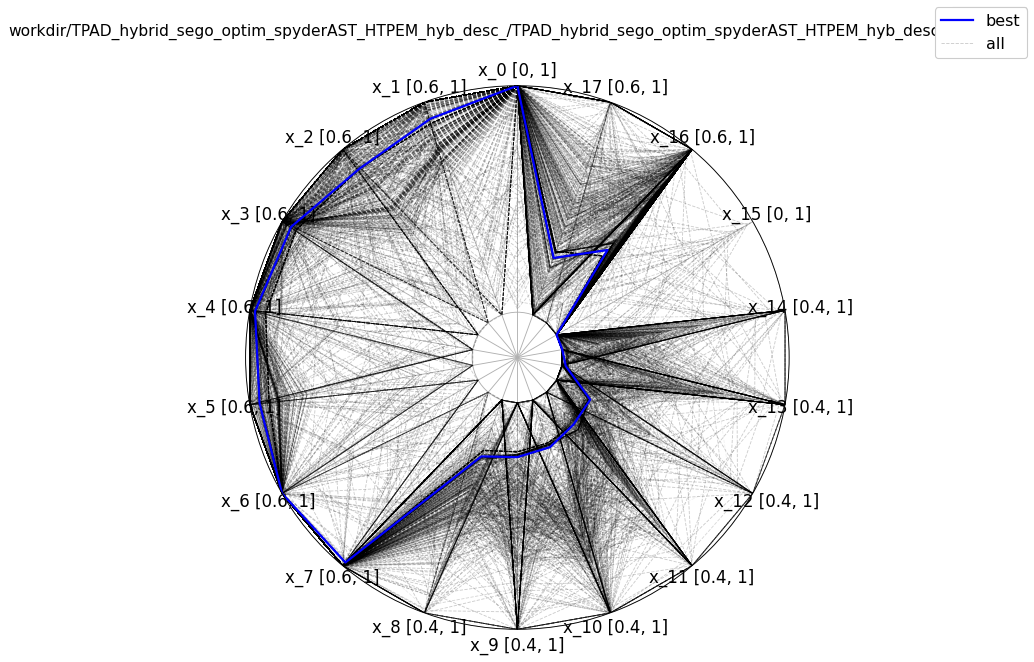

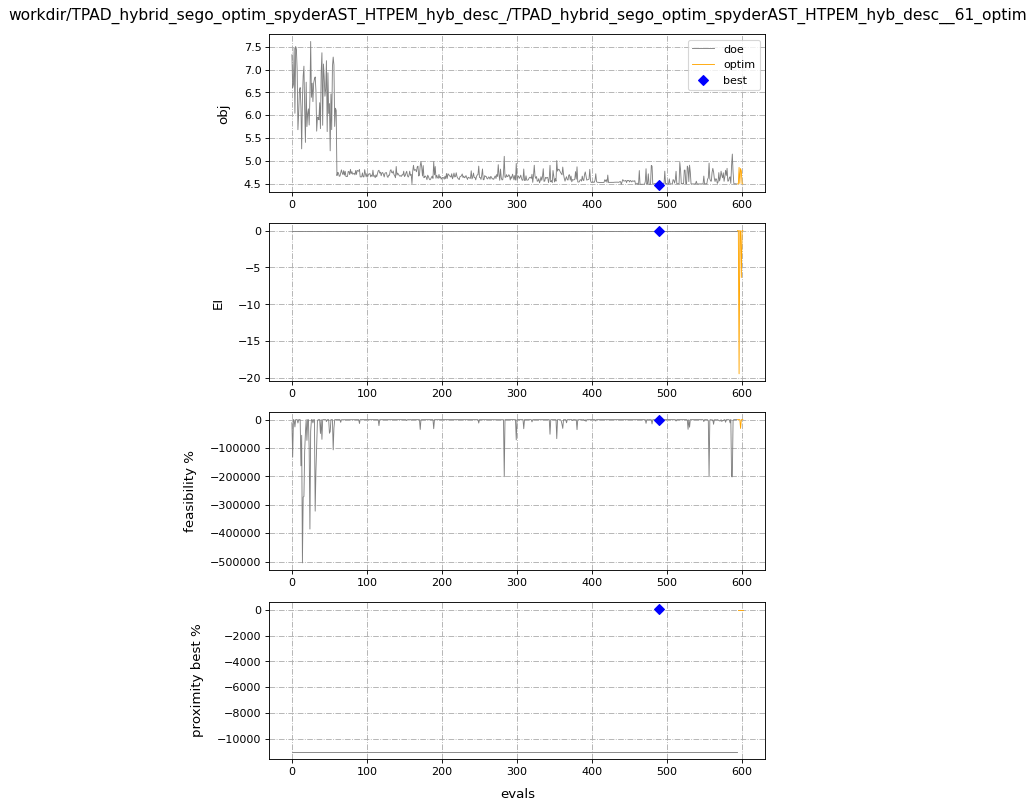

In [6]:
%run run_postproc.py  workdir/TPAD_hybrid_sego_optim_spyderAST_HTPEM_hyb_desc_/TPAD_hybrid_sego_optim_spyderAST_HTPEM_hyb_desc__61_optim -v -d -rt all best -mt doe optim best -s

## LT-PEM


Run: workdir/TPAD_hybrid_sego_optim_spyderAST_LTPEM_hyb_desc/TPAD_hybrid_sego_optim_spyderAST_LTPEM_hyb_desc_44_optim

x_0 [0, 1]
x_1 [0.6, 1]
x_2 [0.6, 1]
x_3 [0.6, 1]
x_4 [0.6, 1]
x_5 [0.6, 1]
x_6 [0.6, 1]
x_7 [0.6, 1]
x_8 [0.4, 1]
x_9 [0.4, 1]
x_10 [0.4, 1]
x_11 [0.4, 1]
x_12 [0.4, 1]
x_13 [0.4, 1]
x_14 [0.4, 1]
x_15 [0, 1]
x_16 [0.6, 1]
x_17 [0.6, 1]

Map eval: ['obj', 'TTC_c1', 'FL_c4', 'OEI_c6', 'TOFL_c7']

Optimization settings:

obj_crit: WB2S
optimizer: slsqp
n_multistart: 36
reclust_rate: 10
analytical_diff: False
smooth_recombination: True

Initial DOE: 823 - n_iter: 0

Best sample:
x=[9.99999997e-01 8.82388918e-01 9.22353986e-01 9.32784474e-01
 9.39026626e-01 9.89290425e-01 9.93779576e-01 9.99999999e-01
 6.01768854e-01 5.81290917e-01 6.10501981e-01 6.03710871e-01
 4.00000000e-01 4.00014087e-01 4.00000003e-01 6.50230923e-09
 7.48027905e-01 7.23818675e-01]
obj=4.82659 valid=True
con=[6.70906060e-01 1.00000000e+00 2.33209967e+03 1.19839330e+02]

Found in doe at 771
Constraint

FileNotFoundError: [Errno 2] No such file or directory: 'workdir/TPAD_hybrid_sego_optim_spyderAST_LTPEM_hyb_desc/TPAD_hybrid_sego_optim_spyderAST_LTPEM_hyb_desc_44_optim\\radar_workdir/TPAD_hybrid_sego_optim_spyderAST_LTPEM_hyb_desc/TPAD_hybrid_sego_optim_spyderAST_LTPEM_hyb_desc_44_optim.png'

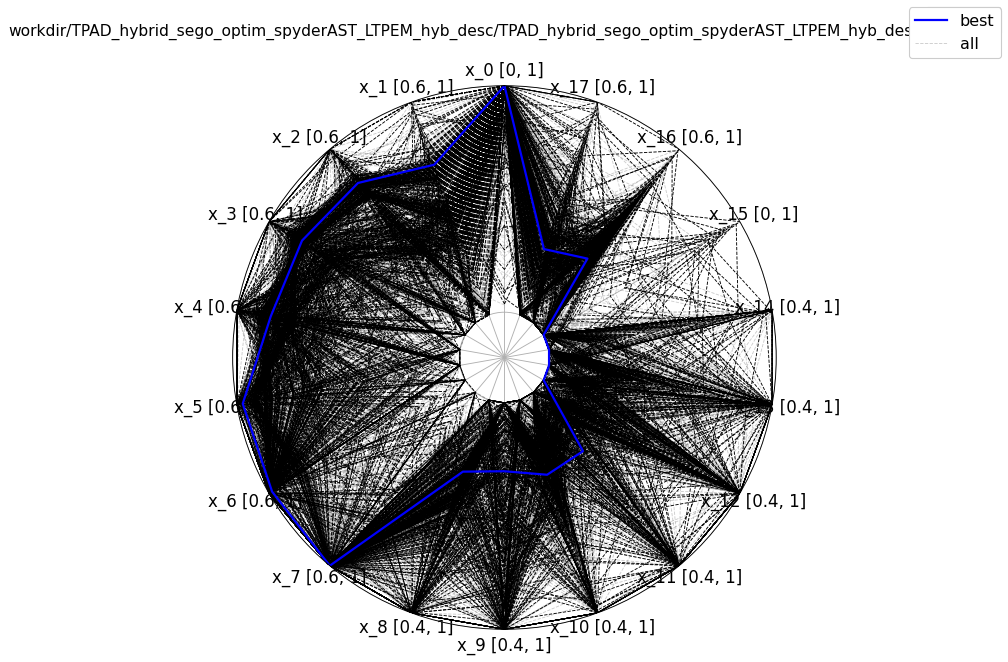

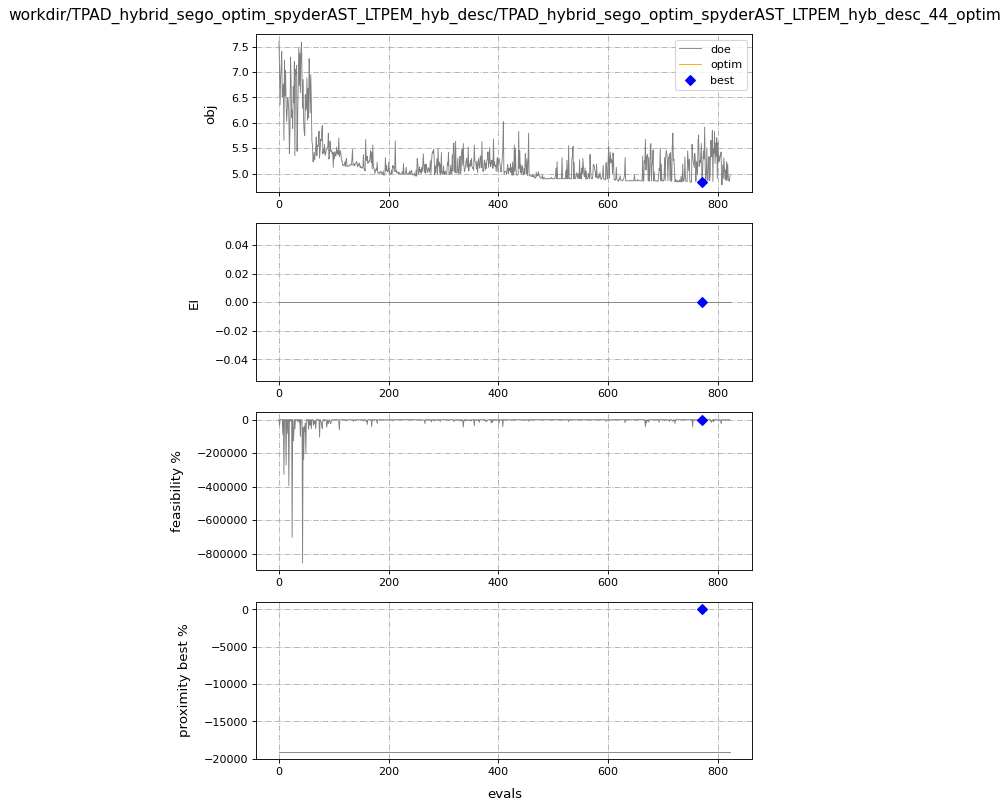

In [15]:
%run run_postproc.py  workdir/TPAD_hybrid_sego_optim_spyderAST_LTPEM_hyb_desc/TPAD_hybrid_sego_optim_spyderAST_LTPEM_hyb_desc_44_optim -v -d -rt all best -mt doe optim best -s

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


obj_constr=np.load('workdir/AST_journal_studies/TPAD_hybrid_sego_optim_spyderAST_LTPEM_hyb_desc/TPAD_hybrid_sego_optim_spyderAST_LTPEM_hyb_desc_43_optim'+'/doe_response.npy')
variabili=np.load('workdir/AST_journal_studies/TPAD_hybrid_sego_optim_spyderAST_LTPEM_hyb_desc/TPAD_hybrid_sego_optim_spyderAST_LTPEM_hyb_desc_43_optim'+'/doe.npy')
c=np.load('workdir/AST_journal_studies/TPAD_hybrid_sego_optim_spyderAST_LTPEM_hyb_desc/TPAD_hybrid_sego_optim_spyderAST_LTPEM_hyb_desc_43_optim'+'/optim_log.npy')


df = pd.DataFrame(data=obj_constr, columns=["bf_pax", "TTC","op_ceiling"  ,"oei_ceiling" ,"TOFL"])
df_LT=df
best= df.loc[df.bf_pax==min(df.bf_pax)]
#display(best)
first_valid_iteration_LT=0

list_current_optim_LT = [] #first value is reference aircraft
for obj in df.bf_pax.values :

    if len(list_current_optim_LT)==0:
        constraints = df.loc[df.bf_pax==obj]
        if constraints.TTC.values[0]>0 and  constraints.op_ceiling.values[0]>0   and constraints.oei_ceiling.values[0]>0  and constraints.TOFL.values[0]>0:
            list_current_optim_LT.append(obj)  
        else:
            first_valid_iteration_LT+=1
    else:
        if obj < list_current_optim_LT[-1]:
            constraints = df.loc[df.bf_pax==obj]
            if constraints.TTC.values[0]>0 and  constraints.op_ceiling.values[0]>0  and constraints.oei_ceiling.values[0]>0  and constraints.TOFL.values[0]>0:
                list_current_optim_LT.append(obj)
            else:
                list_current_optim_LT.append(list_current_optim_LT[-1])
        else:
            list_current_optim_LT.append(list_current_optim_LT[-1])      

best_LT= df.loc[df.bf_pax==min(list_current_optim_LT)]
display(best_LT)                       

,bf_pax,TTC,op_ceiling,oei_ceiling,TOFL
771,4.826591,0.670906,1.0,2332.099666,119.83933


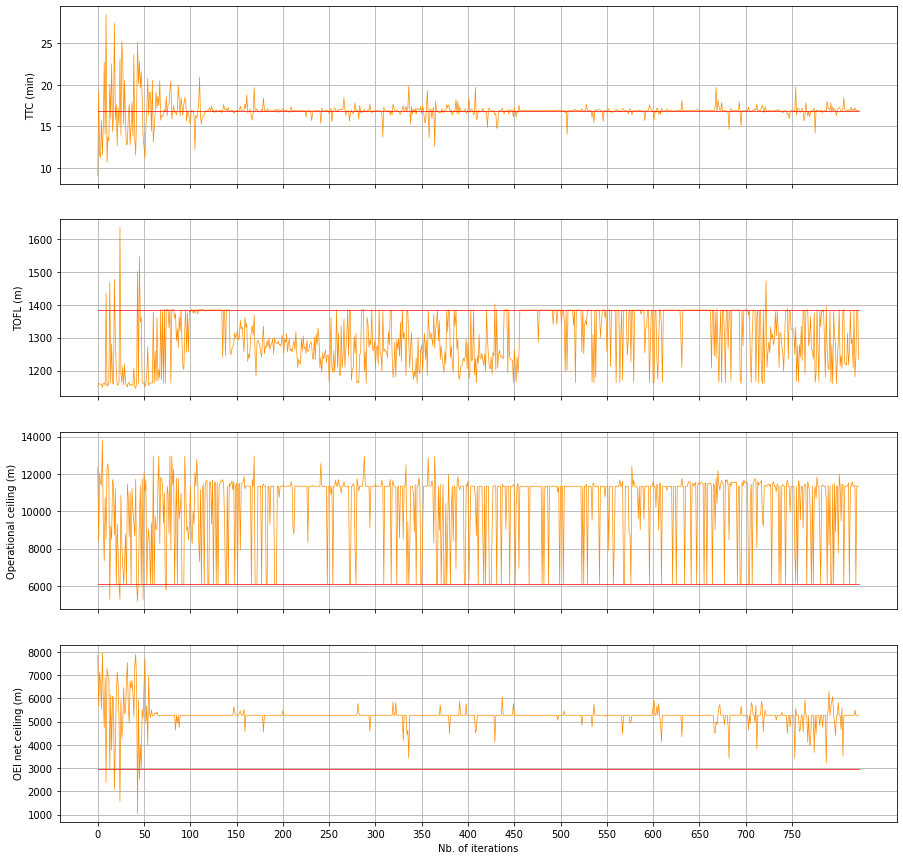

In [3]:
TTC = df['TTC'].apply(lambda x: (-x + 16.9*60)/60).values
TOFL = df['TOFL'].apply(lambda x: -x + 1384).values
op_ceiling= df['op_ceiling'].apply(lambda x: x + 6095).values
#div_ceiling = df['div_ceiling'].apply(lambda x: x + 3047).values
oei_ceiling = df['oei_ceiling'].apply(lambda x: x + 2943).values

#fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(5,figsize=(15,15), sharex=True)
fig, (ax1, ax2,ax3,ax5) = plt.subplots(4,figsize=(15,15), sharex=True)
#fig.suptitle('Vertically stacked subplots')
plt.xticks(  range(0,800,50) )
plt.xlabel('Nb. of iterations')
ax1.plot(TTC ,linewidth=0.7, color='darkorange')
ax1.plot(np.ones(len(TTC))*16.9 ,linewidth=0.7, color='red')
ax1.set_ylabel('TTC (min)')
ax1.grid()

ax2.plot(TOFL ,linewidth=0.7, color='darkorange')
ax2.plot(np.ones(len(TTC))*1384 ,linewidth=0.7, color='red')
ax2.set_ylabel('TOFL (m)')
ax2.grid()

ax3.plot(op_ceiling ,linewidth=0.7, color='darkorange')
ax3.plot(np.ones(len(TTC))*6095 ,linewidth=0.7, color='red')
ax3.set_ylabel('Operational ceiling (m)')
ax3.grid()

'''ax4.plot(div_ceiling ,linewidth=0.7, color='darkorange')
ax4.plot(np.ones(len(TTC))*3047 ,linewidth=0.7, color='red')
ax4.set_ylabel('Diversion ceiling (m)')
ax4.grid()'''

ax5.plot(oei_ceiling ,linewidth=0.7, color='darkorange')
ax5.plot(np.ones(len(TTC))*2943 ,linewidth=0.7, color='red')
ax5.set_ylabel('OEI net ceiling (m)')
ax5.grid()

plt.show()

## HT-PEM


Run: workdir/TPAD_hybrid_sego_optim_spyderAST_HTPEM_hyb_desc_/TPAD_hybrid_sego_optim_spyderAST_HTPEM_hyb_desc__61_optim

x_0 [0, 1]
x_1 [0.6, 1]
x_2 [0.6, 1]
x_3 [0.6, 1]
x_4 [0.6, 1]
x_5 [0.6, 1]
x_6 [0.6, 1]
x_7 [0.6, 1]
x_8 [0.4, 1]
x_9 [0.4, 1]
x_10 [0.4, 1]
x_11 [0.4, 1]
x_12 [0.4, 1]
x_13 [0.4, 1]
x_14 [0.4, 1]
x_15 [0, 1]
x_16 [0.6, 1]
x_17 [0.6, 1]

Map eval: ['obj', 'TTC_c1', 'FL_c4', 'OEI_c6', 'TOFL_c7']

Optimization settings:

obj_crit: WB2S
optimizer: slsqp
n_multistart: 36
reclust_rate: 10
analytical_diff: False
smooth_recombination: True

Initial DOE: 594 - n_iter: 8

Best sample:
x=[1.         0.96885447 0.95481739 0.98141141 0.99046057 0.98239921
 1.         0.99248202 0.55875267 0.54384435 0.53272316 0.51153171
 0.50289559 0.41013511 0.40071063 0.         0.76780853 0.70713279]
obj=4.47544 valid=True
con=[  14.9335577  5182.69155209 2332.09964392  104.64507046]

Found in doe at 489
Constraint mean feasibility: 100 %

463 valid samples with tol=[0.1 0.1 0.1 0.1]
[[1.0

FileNotFoundError: [Errno 2] No such file or directory: 'workdir/TPAD_hybrid_sego_optim_spyderAST_HTPEM_hyb_desc_/TPAD_hybrid_sego_optim_spyderAST_HTPEM_hyb_desc__61_optim\\radar_workdir/TPAD_hybrid_sego_optim_spyderAST_HTPEM_hyb_desc_/TPAD_hybrid_sego_optim_spyderAST_HTPEM_hyb_desc__61_optim.png'

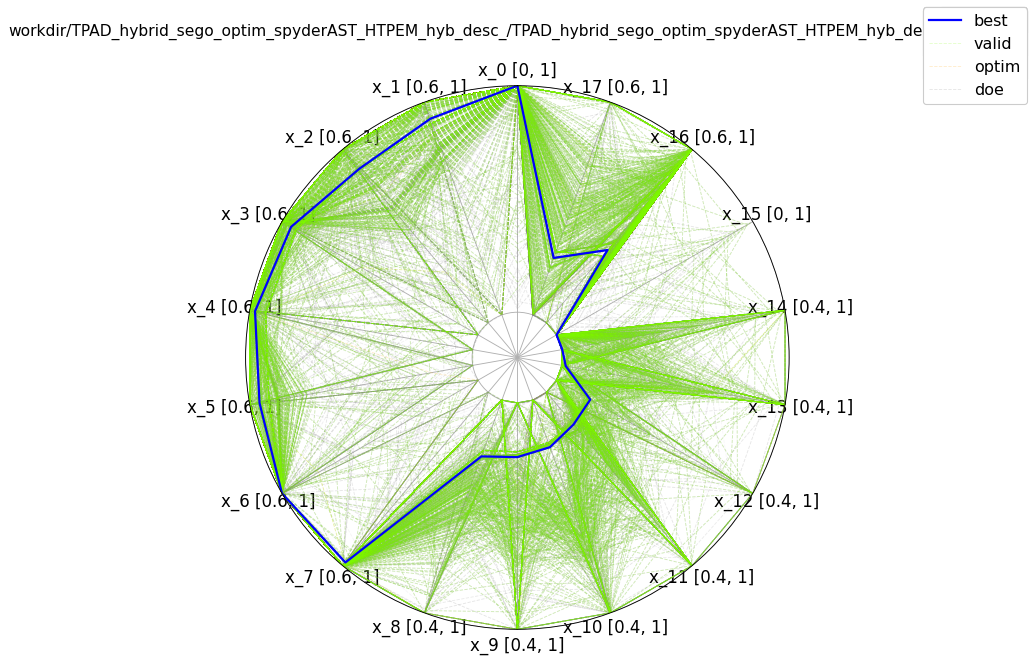

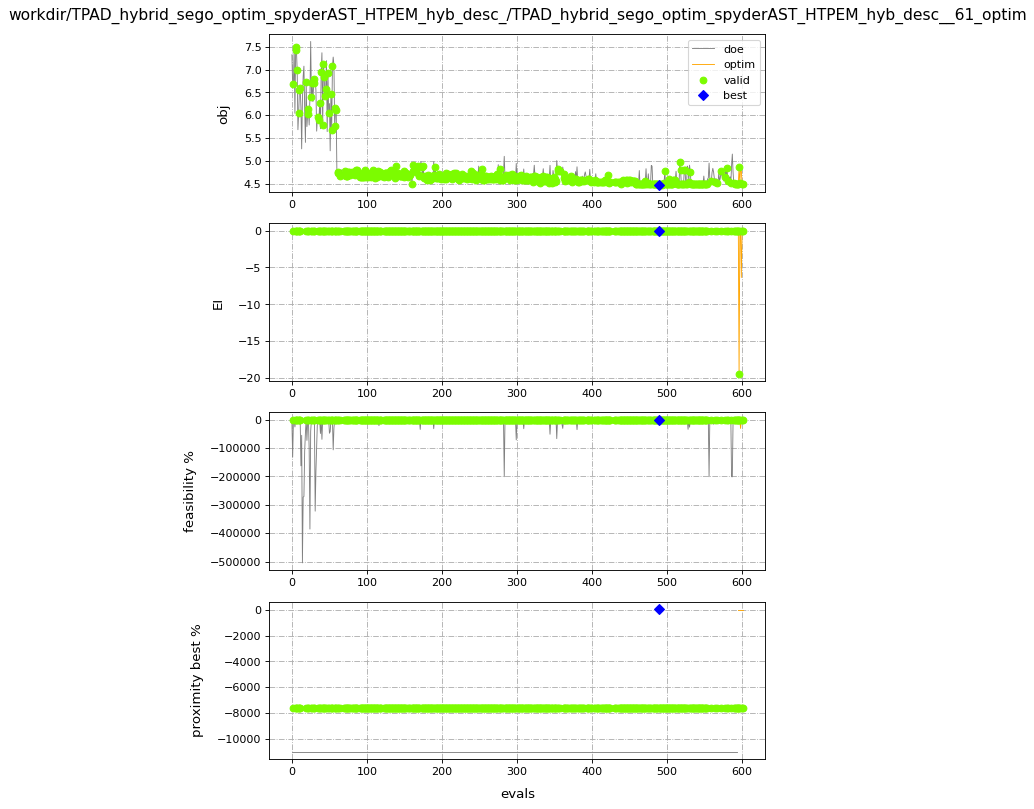

In [19]:
%run run_postproc.py  workdir/TPAD_hybrid_sego_optim_spyderAST_HTPEM_hyb_desc_/TPAD_hybrid_sego_optim_spyderAST_HTPEM_hyb_desc__61_optim -v -d -rt doe optim valid best -mt doe optim valid best -s

In [4]:
import numpy as np
import pandas as pd
obj_constr=np.load('workdir/AST_journal_studies/TPAD_hybrid_sego_optim_spyderAST_HTPEM_hyb_desc_/TPAD_hybrid_sego_optim_spyderAST_HTPEM_hyb_desc__61_optim'+'/doe_response.npy')
variabili=np.load('workdir/AST_journal_studies/TPAD_hybrid_sego_optim_spyderAST_HTPEM_hyb_desc_/TPAD_hybrid_sego_optim_spyderAST_HTPEM_hyb_desc__61_optim'+'/doe.npy')
c=np.load('workdir/AST_journal_studies/TPAD_hybrid_sego_optim_spyderAST_HTPEM_hyb_desc_/TPAD_hybrid_sego_optim_spyderAST_HTPEM_hyb_desc__61_optim'+'/optim_log.npy')


df = pd.DataFrame(data=obj_constr, columns=["bf_pax", "TTC","op_ceiling" ,"oei_ceiling" ,"TOFL"])
df_HT=df
best= df.loc[df.bf_pax==min(df.bf_pax)]
first_valid_iteration_HT=0

list_current_optim_HT = [] #first value is reference aircraft
for obj in df.bf_pax.values :

    if len(list_current_optim_HT)==0:
        constraints = df.loc[df.bf_pax==obj]
        if constraints.TTC.values[0]>0 and  constraints.op_ceiling.values[0]>0  and constraints.oei_ceiling.values[0]>0  and constraints.TOFL.values[0]>0:
            list_current_optim_HT.append(obj)  
        else:
            first_valid_iteration_HT+=1
    else:
        if obj < list_current_optim_HT[-1]:
            constraints = df.loc[df.bf_pax==obj]
            if constraints.TTC.values[0]>0 and  constraints.op_ceiling.values[0]>0  and constraints.oei_ceiling.values[0]>0  and constraints.TOFL.values[0]>0:
                list_current_optim_HT.append(obj)
            else:
                list_current_optim_HT.append(list_current_optim_HT[-1])
        else:
            list_current_optim_HT.append(list_current_optim_HT[-1])      
            
best_HT= df.loc[df.bf_pax==min(list_current_optim_HT)]
display(best_HT)     

,bf_pax,TTC,op_ceiling,oei_ceiling,TOFL
489,4.475436,14.933558,5182.691552,2332.099644,104.64507


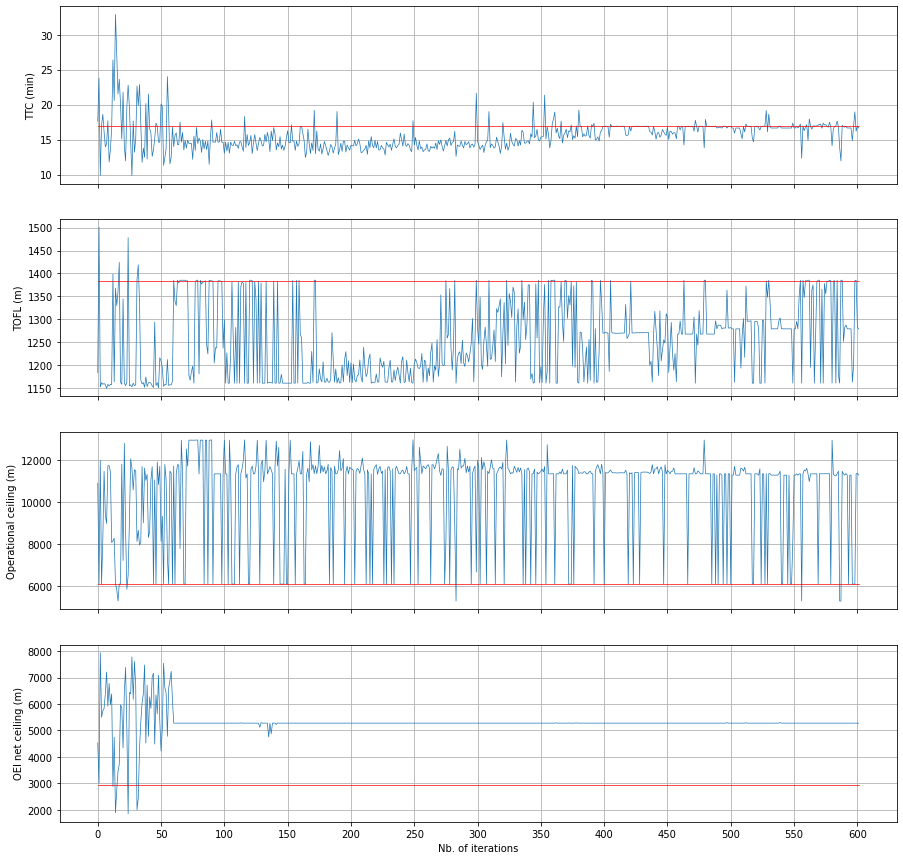

In [6]:
TTC = df['TTC'].apply(lambda x: (-x + 16.9*60)/60).values
TOFL = df['TOFL'].apply(lambda x: -x + 1384).values
op_ceiling= df['op_ceiling'].apply(lambda x: x + 6095).values
#div_ceiling = df['div_ceiling'].apply(lambda x: x + 3047).values
oei_ceiling = df['oei_ceiling'].apply(lambda x: x + 2943).values

#fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(5,figsize=(15,15), sharex=True)
fig, (ax1, ax2,ax3,ax5) = plt.subplots(4,figsize=(15,15), sharex=True)

#fig.suptitle('Vertically stacked subplots')
plt.xticks(  range(0,800,50) )
plt.xlabel('Nb. of iterations')
ax1.plot(TTC ,linewidth=0.7)
ax1.plot(np.ones(len(TTC))*16.9 ,linewidth=0.7, color='red')
ax1.set_ylabel('TTC (min)')
ax1.grid()

ax2.plot(TOFL ,linewidth=0.7)
ax2.plot(np.ones(len(TTC))*1384 ,linewidth=0.7, color='red')
ax2.set_ylabel('TOFL (m)')
ax2.grid()

ax3.plot(op_ceiling ,linewidth=0.7)
ax3.plot(np.ones(len(TTC))*6095 ,linewidth=0.7, color='red')
ax3.set_ylabel('Operational ceiling (m)')
ax3.grid()

'''ax4.plot(div_ceiling ,linewidth=0.7)
ax4.plot(np.ones(len(TTC))*3047 ,linewidth=0.7, color='red')
ax4.set_ylabel('Diversion ceiling (m)')
ax4.grid()'''

ax5.plot(oei_ceiling ,linewidth=0.7)
ax5.plot(np.ones(len(TTC))*2943 ,linewidth=0.7, color='red')
ax5.set_ylabel('OEI net ceiling (m)')
ax5.grid()

plt.show()

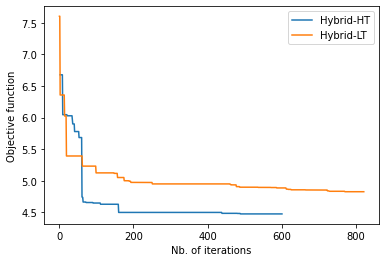

<Figure size 432x288 with 0 Axes>

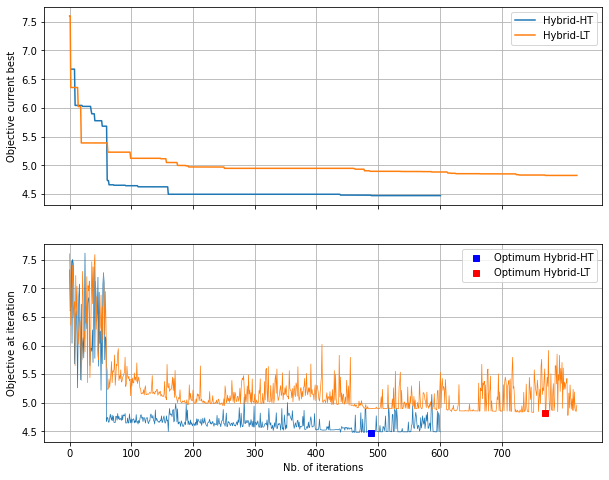

In [9]:
#xticks = np.arange(0, 750, 50)
plt.plot(first_valid_iteration_HT+np.array(range(len(list_current_optim_HT))), list_current_optim_HT, label='Hybrid-HT')    
plt.plot(first_valid_iteration_LT+np.array(range(len(list_current_optim_LT))), list_current_optim_LT, label='Hybrid-LT')    
plt.xlabel('Nb. of iterations')
plt.ylabel('Objective function')
plt.legend()
#plt.xticks(xticks)
#☻plt.grid()
plt.show()

plt.figure()

fig, (ax1, ax2) = plt.subplots(2, figsize=(10,8), sharex=True)
#fig.suptitle('Vertically stacked subplots')
plt.xticks(  range(0,800,100) )
plt.xlabel('Nb. of iterations')

ax1.plot(first_valid_iteration_HT+np.array(range(len(list_current_optim_HT))), list_current_optim_HT,label='Hybrid-HT' )
ax1.plot(first_valid_iteration_LT+np.array(range(len(list_current_optim_LT))), list_current_optim_LT, label='Hybrid-LT')
ax1.set_ylabel('Objective current best')
ax1.grid()
ax1.legend()
# label='_nolegend_'
ax2.plot(range(len(df_HT)),df_HT.bf_pax.values,linewidth=0.7) 
ax2.plot( 489, min(list_current_optim_HT), 'bs', label='Optimum Hybrid-HT')
ax2.plot(range(len(df_LT)),df_LT.bf_pax.values,linewidth=0.7)
ax2.plot(771, min(list_current_optim_LT), 'rs', label='Optimum Hybrid-LT')
ax2.legend()
ax2.set_ylabel('Objective at iteration')
ax2.grid()
plt.show()

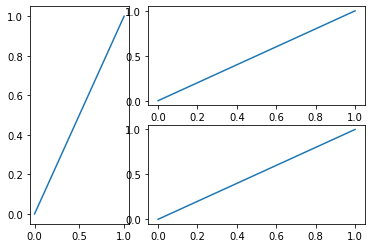

In [161]:
import numpy as np
import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec

# Create 2x2 sub plots
gs = gridspec.GridSpec(2, 3)

pl.figure()
ax = pl.subplot(gs[:, 0]) # row 0, col 0
pl.plot([0,1])

ax = pl.subplot(gs[0, 1:]) # row 0, col 1
pl.plot([0,1])

ax = pl.subplot(gs[1, 1:]) # row 1, span all columns
pl.plot([0,1])